In [1]:
import gpflow
import tensorflow as tf
import numpy as np
import pods
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

/home/mt752/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Data set

In [2]:
data = pods.datasets.mcycle()

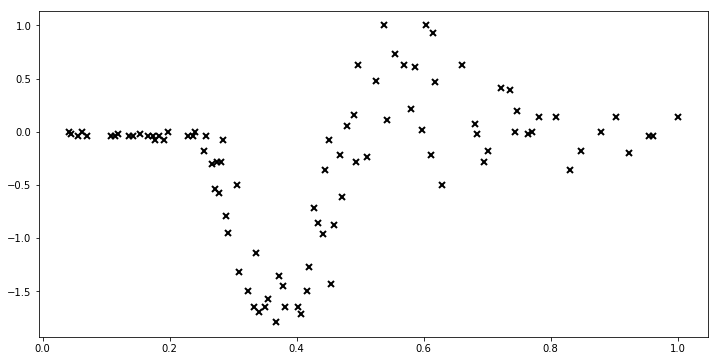

In [3]:
X = data["X"] / np.max(data["X"])
Y = data["Y"] / np.max(data["Y"])
plt.plot(X, Y, 'kx', mew=2)

Construction of a **Gaussian Process Regression** model. 
Other models are:
* GPMC: Gaussian Process Model with MCMC posterior inference on parameters
* SVGP: Stochastic Variational GPs
* ...

In [7]:
k = gpflow.kernels.RBF(1)
k.lengthscales = 0.1
k.variance = 0.1
m = gpflow.models.GPR(X, Y, kern=k)
m.likelihood.variance = 0.05
#m.compile()
#gpflow.train.ScipyOptimizer().minimize(m)

In [8]:
def plot_model(m, xmin, xmax, name=""):
    pX = np.linspace(xmin, xmax, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    
    plt.plot(X, Y, 'x')
    plt.plot(pX, pY)
    try:
        plt.plot(m.feature.Z.value, m.feature.Z.value * 0, 'o')
    except AttributeError:
        pass
    two_sigma = (2.0 * pYv ** 0.5)[:, 0]
    plt.fill_between(pX[:, 0], pY[:, 0] - two_sigma, pY[:, 0] + two_sigma, alpha=0.15)
    lml = m.compute_log_likelihood()
    plt.title("%s (lml = %f)" % (name, lml))
    return m

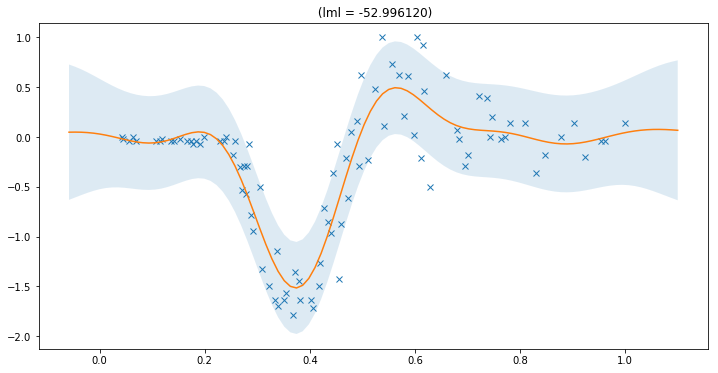

In [9]:
full_lml = plot_model(m, np.min(X) - 0.1, np.max(X) + 0.1)

# SPN of GPs

In [10]:
from gpflow import settings as gpflowSettings
from gpflow.params import ParamList, Parameter
from gpflow.models import Model, GPModel
from gpflow.decors import name_scope, params_as_tensors, autoflow
from gpflow.densities import multivariate_normal
from gpflow.params import DataHolder
from gpflow.likelihoods import Gaussian

In [11]:
class Leaf_GPR(GPModel):
    """
    Gaussian Process Regression.
    """
    def __init__(self, X, Y, kern, likelihoodfun, mean_function=None, **kwargs):
        X = DataHolder(X)
        Y = DataHolder(Y)
        GPModel.__init__(self, X, Y, kern, Gaussian(), mean_function, **kwargs)
        self.num_latent = Y.shape[1]
        self.likelihood.variance = 0.05
    
    @params_as_tensors 
    def updateWeights(self):
        return self.compute_log_likelihood()
    
    @params_as_tensors
    def _build_likelihood(self):
        """
        Construct a tensorflow function to compute the likelihood.
        """
        K = self.kern.K(self.X) + tf.eye(tf.shape(self.X)[0], dtype=gpflowSettings.float_type) * self.likelihood.variance
        L = tf.cholesky(K)
        m = self.mean_function(self.X)

        return multivariate_normal(self.Y, m, L)
    
    @params_as_tensors
    def _build_predict(self, Xnew, full_cov=False):
        Kx = self.kern.K(self.X, Xnew)
        K = self.kern.K(self.X) + tf.eye(tf.shape(self.X)[0], dtype=gpflowSettings.float_type) * self.likelihood.variance
        L = tf.cholesky(K)
        A = tf.matrix_triangular_solve(L, Kx, lower=True)
        V = tf.matrix_triangular_solve(L, self.Y - self.mean_function(self.X))
        fmean = tf.matmul(A, V, transpose_a=True) + self.mean_function(Xnew)
        if full_cov:
            fvar = self.kern.K(Xnew) - tf.matmul(A, A, transpose_a=True)
            shape = tf.stack([1, 1, tf.shape(self.Y)[1]])
            fvar = tf.tile(tf.expand_dims(fvar, 2), shape)
        else:
            fvar = self.kern.Kdiag(Xnew) - tf.reduce_sum(tf.square(A), 0)
            fvar = tf.tile(tf.reshape(fvar, (-1, 1)), [1, tf.shape(self.Y)[1]])
        return fmean, fvar
  
    @params_as_tensors
    def predict_y(self, Xnew):
        """
        Compute the mean and variance of held-out data at the points Xnew
        """
        pred_f_mean, pred_f_var = self._build_predict(Xnew)
        return self.likelihood.predict_mean_and_var(pred_f_mean, pred_f_var)

In [12]:
class Product_GPR(Model):
    """
    SPN over Gaussian Processes for Regression.
    """
    def __init__(self, X, Y, K, minSamplesPercent, depth, maxDepth, kern, likelihoodfun, mean_function=None, **kwargs):
        """
        X is a data matrix, size N x D
        Y is a data matrix, size N x R
        K is the number of mixture components
        minSamples is the minimum number of samples per GP
        kern, mean_function are appropriate GPflow objects
        """
        
        Model.__init__(self)
        
        N = X.shape[0]
        D = X.shape[1]
        
        minSamples = int(N * minSamplesPercent)
                
        s1 = 0
        s2 = 0      
        
        split = np.zeros(D)
        
        for d in range(D):
            c = 0
            while min(s1, s2) < minSamples:
                split[d] = np.random.rand() * np.max(X[:,d]) + np.min(X[:,d])    
                X1 = X[(X <= split[d])]
                X2 = X[(X > split[d])]

                s1 = X1.shape[0]
                s2 = X2.shape[0]

                c += 1

                if c > 100:
                    raise NameError('Could not find a split!')
                    break;
        
        self.split = tf.constant(split)
        
        X1 = np.matrix(X[(X <= split),]).T
        X2 = np.matrix(X[(X > split),]).T
        
        Y1 = np.matrix(Y[(X <= split),]).T
        Y2 = np.matrix(Y[(X > split),]).T
        
        if depth >= maxDepth:
            m1 = Leaf_GPR(X1, Y1, kern, likelihoodfun)
            m2 = Leaf_GPR(X2, Y2, kern, likelihoodfun)
            self.children = ParamList([m1, m2])
        else:
            m1 = Sum_GPR(X1.T, Y1.T, K , minSamplesPercent, depth + 1, maxDepth, kern, likelihoodfun)
            m2 = Sum_GPR(X2.T, Y2.T, K, minSamplesPercent, depth + 1, maxDepth, kern, likelihoodfun)
            self.children = ParamList([m1, m2])

    @params_as_tensors
    def _build_likelihood(self):
        return tf.reduce_sum([m._build_likelihood() for m in self.children])
    
    @params_as_tensors
    def updateWeights(self):
        return tf.reduce_sum([child.updateWeights() for child in self.children])
    
    @params_as_tensors
    def predict_y(self, Xnew):
        
        predictions = [child.predict_y(Xnew) for child in self.children]
            
        mu = [pred[0] for pred in predictions]
        var = [pred[1] for pred in predictions]
        
        condition = tf.less_equal(Xnew, self.split)

        mu = tf.where(condition, mu[0], mu[1])
        var = tf.where(condition, var[0], var[1])

        return mu, var

In [13]:
class Sum_GPR(Model):
    
    """
    SPN over Gaussian Processes for Regression.
    """
    def __init__(self, X, Y, K, minSamplesPercent, depth, maxDepth, kern, likelihoodfun, mean_function=None, **kwargs):
        """
        X is a data matrix, size N x D
        Y is a data matrix, size N x R
        K is the number of mixture components
        minSamples is the minimum number of samples per GP
        kern, mean_function are appropriate GPflow objects
        """
        
        Model.__init__(self)
        
        self.D = X.shape[1]
        self.children = ParamList([Product_GPR(X, Y, K, minSamplesPercent, depth, maxDepth, kern, likelihoodfun) for k in range(K)])
        self.prior_logweights = Parameter(np.log(np.ones(K) / K))
        self.likelihood_logweights = tf.Variable(np.log(np.ones(K) / K))
        
    @params_as_tensors
    def _build_likelihood(self):
        """
        Construct a tensorflow function to compute the likelihood.
        """
        
        prods = tf.stack([child._build_likelihood() for child in self.children])
        weights = tf.nn.log_softmax(self.prior_logweights)
        return tf.reduce_logsumexp(prods + weights)
    
    @params_as_tensors
    def updateWeights(self):
        logfactors = [child.updateWeights() for child in self.children]
        print(type(logfactors))
        updateW = self.likelihood_logweights + logfactors
        Z = tf.reduce_logsumexp(updateW)
        tf.assign(self.likelihood_logweights, updateW - Z)
        return Z
    
    @params_as_tensors
    def predict_y(self, Xnew):
        
        predictions = [child.predict_y(Xnew) for child in self.children]
        #prior_weights = tf.expand_dims(tf.nn.softmax(self.prior_logweights), 0)
        #likelihood_weights = tf.expand_dims(self.likelihood_logweights, 0)
        
        # compute posterior weights
        weights = tf.expand_dims(tf.nn.softmax(self.prior_logweights + self.likelihood_logweights), 0)
            
        mu = tf.stack([pred[0] for pred in predictions])
        var = tf.stack([pred[1] for pred in predictions])
                
        # sum_k w_k * mu_k
        mus = [tf.squeeze(tf.matmul(weights, mu[:,:,0])) for d in range(self.D)]
        ymean = tf.transpose(tf.stack(mus))
        
        # sum_k w_k * sigma^2 + sum_k w_k (mu_k)^2 - (sum_k w_k mu_k)^2
        yvar = tf.transpose(tf.stack([tf.squeeze(tf.matmul(weights, var[:,:,0])) for d in range(self.D)]))
        yvar += tf.transpose(tf.stack([tf.squeeze(tf.matmul(weights, tf.square(mu[:,:,d]))) for d in range(self.D)]))
        yvar -= tf.square(ymean)
        
        return ymean, yvar

In [14]:
class SPN_GPR(Model):
    
    """
    SPN over Gaussian Processes for Regression.
    """
    def __init__(self, X, Y, K, minSamplesPercent, depth, maxDepth, kern, likelihoodfun, mean_function=None, **kwargs):
        """
        X is a data matrix, size N x D
        Y is a data matrix, size N x R
        K is the number of mixture components
        minSamples is the minimum number of samples per GP
        kern, mean_function are appropriate GPflow objects
        """
        Model.__init__(self)
        self.rootNode = ParamList([Sum_GPR(X, Y, K, minSamplesPercent, depth, maxDepth, kern, likelihoodfun)])
        
        
    @params_as_tensors
    def _build_likelihood(self):
        return self.rootNode[0]._build_likelihood()

    @params_as_tensors
    def updateWeights(self):
        self.rootNode[0].updateWeights()
        
    @params_as_tensors
    @autoflow((gpflowSettings.tf_float, [None, None]))
    def predict_y(self, Xnew):
        return self.rootNode[0].predict_y(Xnew)

In [15]:
k = gpflow.kernels.RBF(1)
k.lengthscales = 0.1
k.variance = 0.1
likelihoodfun = Gaussian()
#likelihoodfun.variance = 0.05

In [16]:
spn = SPN_GPR(X, Y, 4, 0.25, 1, 1, k, likelihoodfun)
#spn.compile()

In [17]:
spn.compute_log_likelihood()

-61.712654728194025

In [18]:
full_lml = plot_model(spn, np.min(X) - 0.1, np.max(X) + 0.1)

FailedPreconditionError: Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_DOUBLE, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](Variable)]]

Caused by op 'Variable/read', defined at:
  File "/home/mt752/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mt752/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-82adf05b5beb>", line 1, in <module>
    spn = SPN_GPR(X, Y, 4, 0.25, 1, 1, k, likelihoodfun)
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 86, in __init__
    origin_init(self, *args, **kwargs)
  File "<ipython-input-14-ac4ade7534d0>", line 15, in __init__
    self.rootNode = ParamList([Sum_GPR(X, Y, K, minSamplesPercent, depth, maxDepth, kern, likelihoodfun)])
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 86, in __init__
    origin_init(self, *args, **kwargs)
  File "<ipython-input-13-fc3a51d0b41f>", line 21, in __init__
    self.likelihood_logweights = tf.Variable(np.log(np.ones(K) / K))
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 213, in __init__
    constraint=constraint)
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 356, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 125, in identity
    return gen_array_ops.identity(input, name=name)
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2071, in identity
    "Identity", input=input, name=name)
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/mt752/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_DOUBLE, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](Variable)]]


In [242]:
spn.updateWeights()

<class 'list'>


TypeError: Expected float64, got list containing Tensors of type '_Message' instead.

In [223]:
spn

/home/mt752/anaconda3/lib/python3.6/site-packages/gpflow/misc.py:30: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  df = df.reindex_axis(keys, axis=1)


                                                        class prior transform  \
SPN_GPR/rootNode/item0/children/item3/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/children/item3/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/children/item0/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/children/item3/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/children/item3/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/children/item0/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/children/item3/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/children/item3/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/children/item1/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/children/item3/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/children/item3/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/child

In [78]:
opt = gpflow.training.AdamOptimizer()
opt.minimize(spn)

In [70]:
spn.compute_log_likelihood()

-34.095645842052441

/home/mt752/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


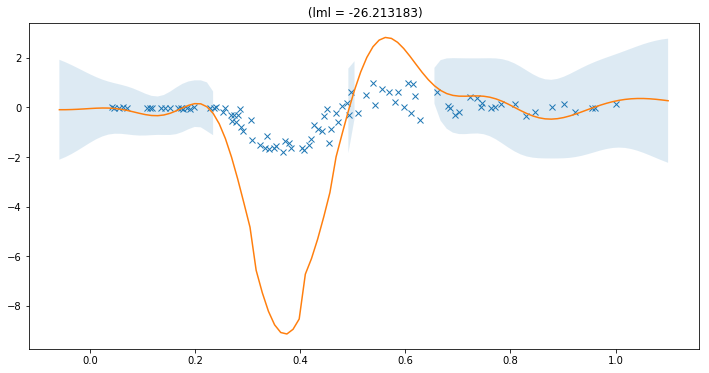

In [79]:
full_lml = plot_model(spn, np.min(X) - 0.1, np.max(X) + 0.1)

In [80]:
print(spn)

                                                        class prior transform  \
SPN_GPR/rootNode/item0/children/item3/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/children/item3/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/children/item0/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/children/item3/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/children/item3/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/children/item0/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/children/item3/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/children/item3/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/children/item1/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/children/item3/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/children/item3/children/...  Parameter  None       +ve   
SPN_GPR/rootNode/item0/child

/home/mt752/anaconda3/lib/python3.6/site-packages/gpflow/misc.py:30: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  df = df.reindex_axis(keys, axis=1)


In [ ]:
K = 10
experts = 2
minSamples = 25

# list of experts
poe = []
allSplitsPos = []

for k in range(K):
    # splits (random in this case)
    split = np.random.rand() * np.max(X) + np.min(X)    
    X1 = X[(X <= split)]
    X2 = X[(X > split)]
    
    s1 = X1.shape[0]
    s2 = X2.shape[0]
    
    while min(s1, s2) < minSamples:
        split = np.random.rand() * np.max(X) + np.min(X)    
        X1 = X[(X <= split)]
        X2 = X[(X > split)]

        s1 = X1.shape[0]
        s2 = X2.shape[0]
    
    allSplitsPos.append(split)

    print("Split positions: ", split)

### Training of Experts


In [44]:
for k in range(K):
    ppoe = []
    split = allSplitsPos[k]
    
    X1 = X[(X <= split)]
    X2 = X[(X > split)]
    
    Y1 = Y[(X <= split)]
    Y2 = Y[(X > split)]
    
    k1 = gpflow.kernels.RBF(1)
    m1 = gpflow.models.GPR(np.matrix(X1).T, np.matrix(Y1).T, kern=k1)
    m1.compile()
    gpflow.train.ScipyOptimizer().minimize(m1)
    ppoe.append(m1)
    
    k2 = gpflow.kernels.RBF(1)
    m2 = gpflow.models.GPR(np.matrix(X2).T, np.matrix(Y2).T, kern=k2)
    m2.compile()
    gpflow.train.ScipyOptimizer().minimize(m2)
    ppoe.append(m2)
    
    poe.append(ppoe)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 189.699401
  Number of iterations: 40
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 245.201307
  Number of iterations: 40
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 197.562444
  Number of iterations: 39
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 234.188879
  Number of iterations: 41
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 280.988068
  Nu

In [61]:
def plotSPNModel(allM, splits, K, xstart, xend):
    xx = np.linspace(xstart, xend, 100)[:,None]
    
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    
    ymean = np.zeros((len(xx), K))
    yvar = np.zeros((len(xx), K))
    
    for k in range(K):
        M = allM[k]
        split = splits[k]
        
        xx1 = xx[(xx[:,0] <= split),:]
        xx2 = xx[(xx[:,0] > split),:]

        mean1, var1 = M[0].predict_y(xx1)
        mean2, var2 = M[1].predict_y(xx2)
        
        ymean[(xx[:,0] <= split),k] = mean1[:,0]
        ymean[(xx[:,0] > split),k] = mean2[:,0]
        
        yvar[(xx[:,0] <= split),k] = var1[:,0]
        yvar[(xx[:,0] > split),k] = var2[:,0]
                
    ymean = np.mean(ymean, 1)
    yvar = np.mean(yvar, 1)
    yvar += np.mean(np.power(ymean, 2)) 
    yvar -= np.power(np.mean(ymean), 2)
    
    plt.plot(xx, ymean, 'b', lw=2)
    plt.fill_between(xx[:,0], ymean - 2*np.sqrt(yvar), ymean + 2*np.sqrt(yvar), color='blue', alpha=0.2)
    plt.xlim(xstart, xend)

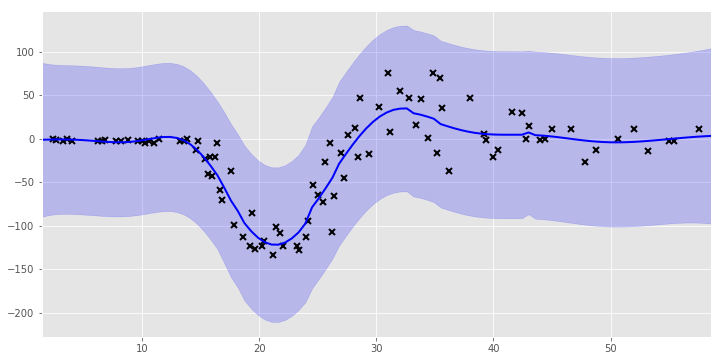

In [62]:
plotSPNModel(poe, allSplitsPos, K, np.min(X) - 1, np.max(X) + 1)

In [99]:
lpd = np.zeros((X.shape[0], K))

for k in range(K):
    M = poe[k]
    split = allSplitsPos[k]

    X1 = X[(X <= split)]
    X2 = X[(X > split)]
    
    Y1 = Y[(X <= split)]
    Y2 = Y[(X > split)]

    lpd1 = M[0].predict_density(np.asmatrix(X1).T, np.asmatrix(Y1).T)
    lpd2 = M[1].predict_density(np.asmatrix(X2).T, np.asmatrix(Y2).T)

    lpd[(X <= split),k] = lpd1[:,0]
    lpd[(X > split),k] = lpd2[:,0]

In [100]:
from scipy.misc import logsumexp

In [103]:
np.sum(logsumexp(lpd, axis = 1))

-188.22275230016993